In [1]:
# download necessary packages

In [3]:
!pip install opencv-python
!pip install scikit-learn
!pip install easydict
!pip install imutils
!pip install tqdm
!pip install timm


# Imprting necessary packages

In [4]:
from collections import Counter
import os

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from easydict import EasyDict as edict
from imutils.paths import list_images
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import *
import torch.optim as optim
from tqdm.auto import tqdm
from PIL import Image
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import timm
import cv2

### Define utility functions

In [5]:
## prepare image and labels using numpy and opencv
def build_dataset(dataset_path, size = None):
    image_paths    = sorted(list_images(dataset_path))
    images, labels = [], []

    
    for image_path in image_paths:
        image  = cv2.imread(image_path)
        resize = (size + 15, size + 15) if size != None else (image.shape[0] + 15, image.shape[1] + 15)
        
        try:
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, resize)
          
          labels.append(image_path.split(os.path.sep)[-2])
          images.append(image)
          
        except Exception as e:
            print(e)
    
    label_names    = set(labels)
    lb2idx         = {lb : idx for idx, lb in enumerate(label_names)}
    idx2lb         = {idx  : lb for lb, idx in lb2idx.items()}
    
    labels         = [lb2idx[lb] for lb in labels]
    images, labels = np.array(images), np.array(labels)
        
    return (images, labels), (lb2idx, idx2lb)


## draw bar graph of number of datas for each labels
def display_distribution(labels, add_num = 100, dtype = 'train'):
    
  lb_count  = Counter(labels)
  max_count = max(lb_count.values())
  
  plt.bar(lb_count.keys(), lb_count.values())
  plt.ylim(0, max_count + add_num)
  plt.title(f'{dtype} dataset')
    
  for grade, num in lb_count.items():
      plt.text(
                  grade, num, num,
                  fontsize = 11, color = 'black',
                  horizontalalignment = 'center',
                  verticalalignment = 'bottom'
              )
  plt.show()


## display train, test loss and accuracy graph
def display_history(history, epoch):
    
    f, axes = plt.subplots(1, 2)
    f.set_size_inches((20, 5))

    for idx, label in enumerate(['acc', 'loss']):
        
        loc = 'lower right' if label == 'loss' else 'upper right'
        
        axes[idx].plot(range(epoch), history[f'train_{label}'], 'y', label = f'train_{label}')
        axes[idx].plot(range(epoch),  history[f'valid_{label}'], 'b',  label = f'valid_{label}')
        axes[idx].set_title(f'Train, Valid {label} Graph')
        axes[idx].legend(loc=loc)
        axes[idx].set_ylabel(f'{label} value')
        axes[idx].set_xlabel('epoch')


### Load Dataset & set configuration

In [6]:
args              = {}
args['n_samples'] = 5
args['seed']      = 99
args['lr']        = 1e-3
args['bs']        = 64
args['epochs']    = 60
args['device']    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args              = edict(args)

In [7]:
## Loading Images and labels
(images, labels), (lb2idx, idx2lb) = build_dataset('./datasets')
lb2idx, idx2lb

({'Half': 0, 'Eight': 1, 'Sixteenth': 2, 'Quarter': 3, 'Whole': 4},
 {0: 'Half', 1: 'Eight', 2: 'Sixteenth', 3: 'Quarter', 4: 'Whole'})

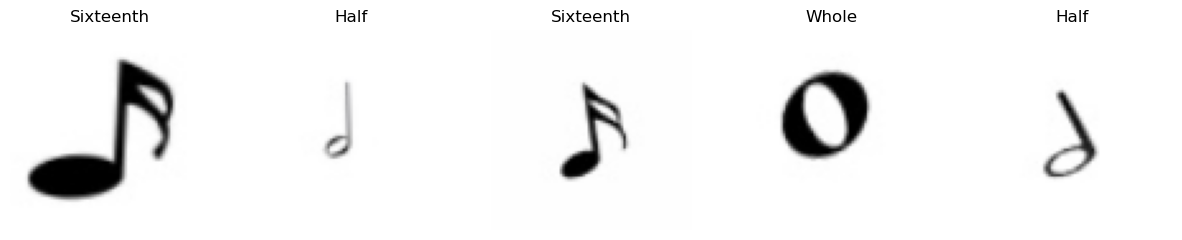

In [8]:
## display 5 sample images and labels
indexes     = np.random.randint(0, len(images), args.n_samples)
_, axes     = plt.subplots(1, 5, figsize = (args.n_samples * 3, args.n_samples))

for idx, ax in zip(indexes, axes):
    
    image = images[idx]
    label = labels[idx]
    
    ax.imshow(image, cmap = 'gray')
    ax.axis(False)
    ax.set_title(idx2lb[label])

In [9]:
## split train, test, valid dataset
train_x, valid_x, train_y, valid_y = train_test_split(images, labels, test_size = 0.2, shuffle = True,
                                                      stratify = labels, random_state = args.seed)
train_x, test_x , train_y, test_y  = train_test_split(train_x, train_y, test_size = 0.16, shuffle = True,
                                                      stratify = train_y, random_state = args.seed)

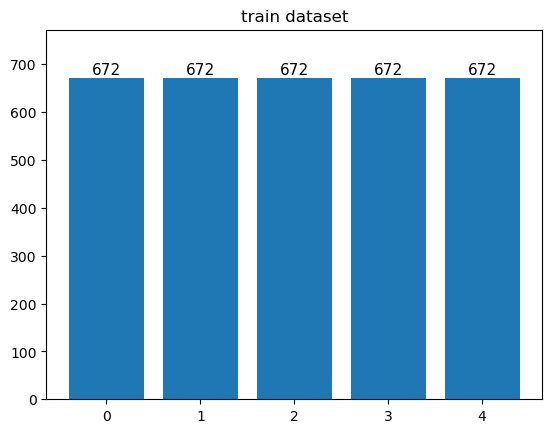

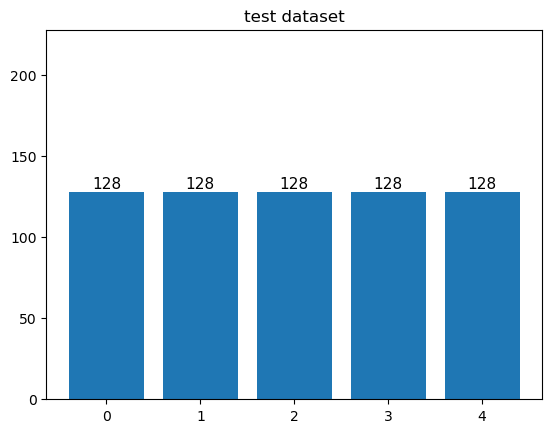

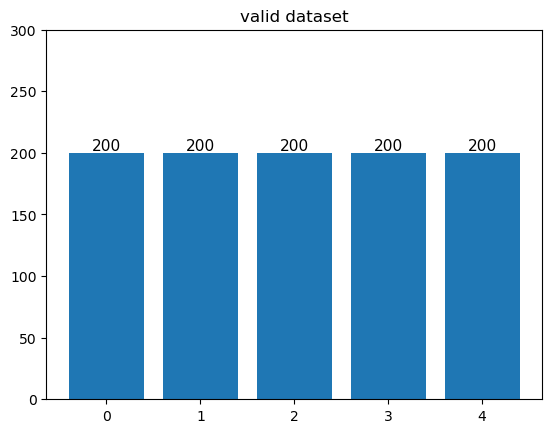

In [10]:
display_distribution(train_y)
display_distribution(test_y , dtype =  'test')
display_distribution(valid_y, dtype = 'valid')

In [11]:
## define Dataset class using pytorch API
class NoteDataset(Dataset):
    
    def __init__(self, images, labels, dtype = 'train'):
        
        self.images = images
        self.labels = labels
        self.dtype  = dtype
        
        self.transforms = {}
        self.transforms['train'] = transforms.Compose([
                                        transforms.ToPILImage(),
            
                                        ## randomly rotating -60 deg ~ 60 deg
                                        transforms.RandomRotation((-np.pi / 3, np.pi / 3)),
                                        transforms.Resize(64),
                                        transforms.ToTensor()
                                    ])
        
        self.transforms['test'] = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize(64),
                                        transforms.ToTensor()
                                        
                                    ])
        
    def __len__(self):
        return len(self.labels)
    
    
    def __getitem__(self, idx):
        
        image = self.images[idx]
        image = self.transforms[self.dtype](image)
        
        return image, self.labels[idx]

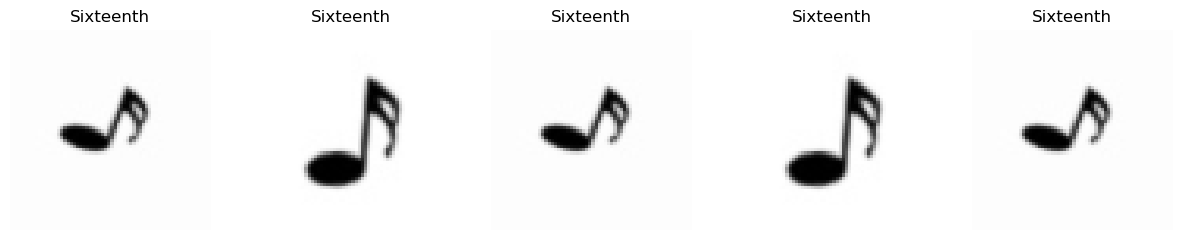

In [12]:
train_dataset = NoteDataset(train_x, train_y)
test_dataset  = NoteDataset( test_x,  test_y, dtype = 'test')
valid_dataset = NoteDataset(valid_x, valid_y, dtype = 'test')

train_loader  = DataLoader(train_dataset, batch_size = args.bs, shuffle =  True)
test_loader   = DataLoader(test_dataset , batch_size = args.bs, shuffle = False)
valid_loader  = DataLoader(valid_dataset, batch_size =       1, shuffle =  True)

samples = next(iter(train_loader))
indexes = np.random.randint(0, len(samples), args.n_samples)
_, axes = plt.subplots(1, args.n_samples, figsize = (3 * args.n_samples, args.n_samples))

for idx, ax in zip(indexes, axes):
    
    image = samples[0][idx]
    label = samples[1][idx]
    ax.imshow(image.numpy().transpose(1, 2, 0), cmap = 'gray')
    ax.axis(False)
    ax.set_title(idx2lb[label.item()])

### Define neural network, optimizer and loss function

In [13]:
## My network is shallow Convolutional Network
class NoteNet(nn.Module):
    
    def __init__(self, n_classes):
        
        super(NoteNet, self).__init__()
        self.conv1 = nn.Conv2d(3,  8, kernel_size = 3, stride = 1, padding = 1)
        self.bn1   = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size = 3, stride = 1, padding = 1)
        self.bn2   = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(16, 8, kernel_size = 3, stride = 1, padding = 1)
        self.bn3   = nn.BatchNorm2d(8)
        
        self.drop  = nn.Dropout2d()
        self.fc1   = nn.Linear(8*8*8, 32)
        self.fc2   = nn.Linear(32, 16)
        self.fc3   = nn.Linear(16, 8)
        self.fc4   = nn.Linear(8, n_classes)
        
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.bn1(x)
        
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.bn2(x)
        
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = self.bn3(x)
        
        x = x.view(-1, 8*8*8)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x, dim = 1)

In [14]:
model         = NoteNet(n_classes = len(idx2lb)).to(args.device)
optimizer     = optim.Adam(model.parameters(), lr = args.lr)
loss_function = torch.nn.CrossEntropyLoss()

logs          = {
                    'train_acc'  : [],
                    'train_loss' : [],
                    'valid_acc'  : [],
                    'valid_loss' : []
                }

### Training and evaluating

In [15]:
def train(model, loader, optim):
    
    correct = 0
    loss    = 0
    
    model.train()
    for batch in loader:
        
        image, label = batch
        image  = image.to(args.device)
        label  = label.to(args.device)
        optim.zero_grad()
        
        output = model(image)
        loss_  = loss_function(output, label.to(torch.long))
        
        loss_.backward()
        optim.step()
        
        pred   = output.max(1, keepdim = True)[1]
        correct += pred.eq(label.view_as(pred)).sum().item()
        loss    += loss_.item()
        
        
    loss /= len(loader.dataset)
    acc   = 100 * correct / len(loader.dataset)
    
    return loss, acc


def evaluate(model, loader):
    
    correct = 0
    loss    = 0
    
    model.eval()
    with torch.no_grad():
        for batch in loader:
            image, label = batch
            image        = image.to(args.device)
            label        = label.to(args.device)

            output       = model(image)
            loss_        = loss_function(output,label.to(torch.long))
            pred         = output.max(1, keepdim = True)[1]
            
            correct     += pred.eq(label.view_as(pred)).sum().item()
            loss        += loss_.item()
    
    loss /= len(loader.dataset)
    acc   = 100 * correct / len(loader.dataset)
    
    return loss, acc

In [16]:
for epoch in range(1, args.epochs + 1):
    
    train_loss, train_acc = train(model, train_loader, optimizer)
    test_loss , test_acc  = evaluate(model, test_loader)
    
    logs['train_acc'].append(train_acc)
    logs['train_loss'].append(train_loss)
    
    logs['valid_acc'].append(test_acc)
    logs['valid_loss'].append(test_loss)
    
    print(f'[{epoch}/{args.epochs}]')
    print(f'[TRAIN] loss : {train_loss:.3f} / accuracy : {train_acc:.3f}%')
    print(f'[TEST]  loss : {test_loss:.3f}  / accuracy : {test_acc:.3f}%\n')

C:\Users\asus\anaconda3\Lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


[1/60]
[TRAIN] loss : 0.024 / accuracy : 31.161%
[TEST]  loss : 0.023  / accuracy : 33.438%

[2/60]
[TRAIN] loss : 0.019 / accuracy : 49.226%
[TEST]  loss : 0.013  / accuracy : 70.625%

[3/60]
[TRAIN] loss : 0.014 / accuracy : 62.143%
[TEST]  loss : 0.010  / accuracy : 71.875%

[4/60]
[TRAIN] loss : 0.011 / accuracy : 67.857%
[TEST]  loss : 0.007  / accuracy : 80.938%

[5/60]
[TRAIN] loss : 0.010 / accuracy : 74.435%
[TEST]  loss : 0.046  / accuracy : 39.844%

[6/60]
[TRAIN] loss : 0.008 / accuracy : 78.304%
[TEST]  loss : 0.011  / accuracy : 72.812%

[7/60]
[TRAIN] loss : 0.007 / accuracy : 82.232%
[TEST]  loss : 0.010  / accuracy : 80.938%

[8/60]
[TRAIN] loss : 0.006 / accuracy : 84.792%
[TEST]  loss : 0.003  / accuracy : 94.375%

[9/60]
[TRAIN] loss : 0.005 / accuracy : 86.190%
[TEST]  loss : 0.009  / accuracy : 78.438%

[10/60]
[TRAIN] loss : 0.005 / accuracy : 87.976%
[TEST]  loss : 0.001  / accuracy : 98.281%

[11/60]
[TRAIN] loss : 0.005 / accuracy : 87.708%
[TEST]  loss : 0.01

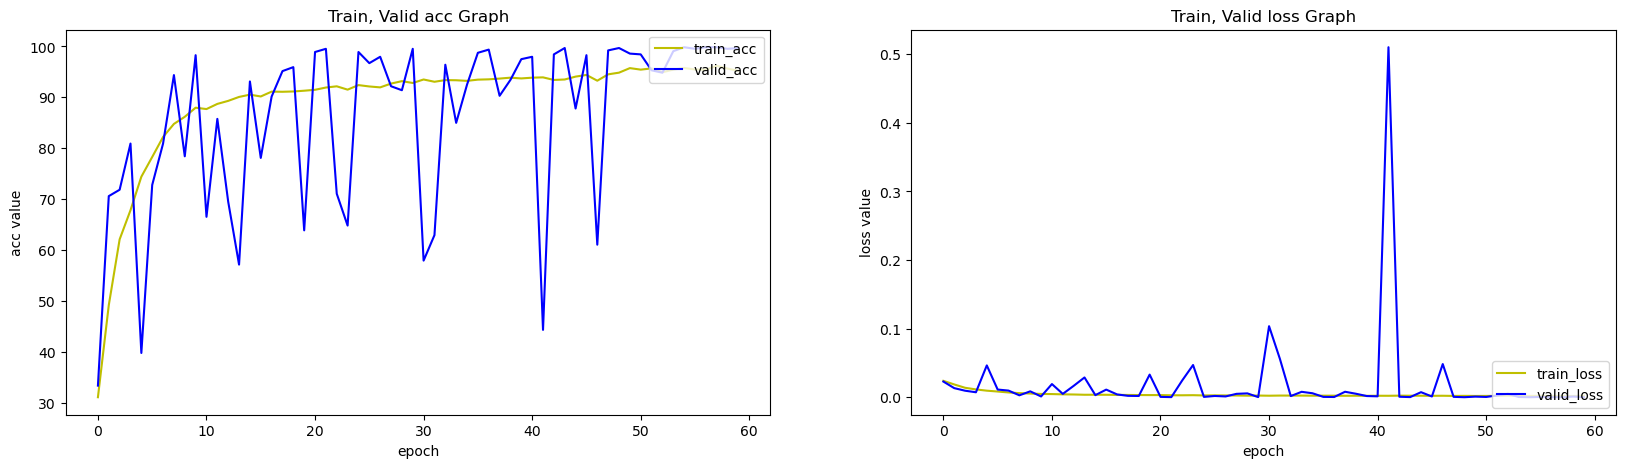

In [17]:
## display training and testing log
display_history(logs, args.epochs)

In [18]:
## evaluation using validation dataset
gt, predicted = [], []
to_numpy      = lambda x: x.detach().cpu().numpy() if x.is_cuda else x.cpu().numpy()

model.eval()
with torch.no_grad():
    
    for batch in valid_loader:
        
        image, label = batch
        image = image.to(args.device)
        label = label.to(args.device)
        
        output = model(image)
        pred   = output.max(1, keepdim = True)[1]
        
        gt.extend(to_numpy(label))
        predicted.extend(to_numpy(pred[0]))

In [19]:
print(f'[VALIDATION] accuracy score : {accuracy_score(gt, predicted)}')
print(classification_report(gt, predicted))

[VALIDATION] accuracy score : 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       0.99      1.00      1.00       200
           2       1.00      1.00      1.00       200
           3       1.00      0.99      1.00       200
           4       1.00      0.99      0.99       200

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



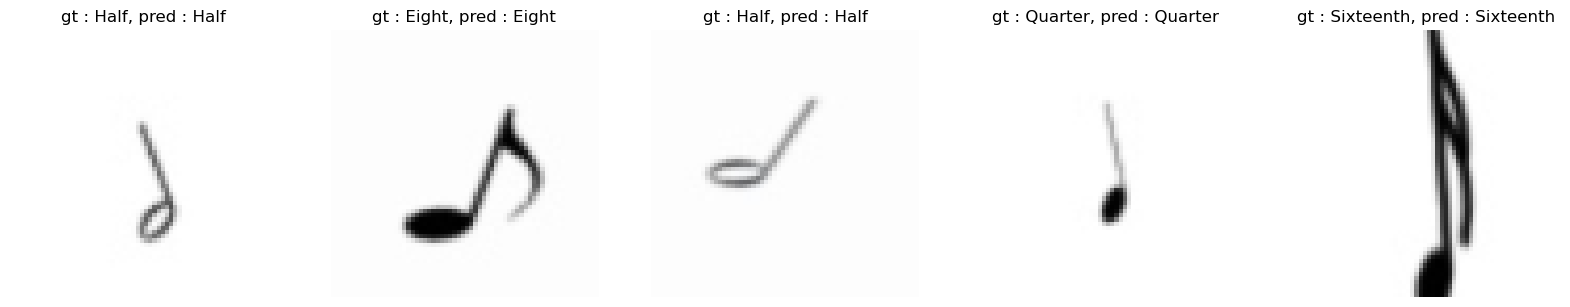

In [24]:
_, axes = plt.subplots(1, args.n_samples, figsize = (4*args.n_samples, 4*args.n_samples))

for ax in axes:
    samples = next(iter(valid_loader))

    with torch.no_grad():

        image   = samples[0].to(args.device)
        label   = samples[1].to(args.device)
        output  = model(image)
        pred    = output.max(1, keepdim = True)[1]
        

        gt_lb   = idx2lb[int(to_numpy(label))]
        pred_lb = idx2lb[to_numpy(pred)[0][0]]
        
        ax.imshow(image.squeeze().numpy().transpose(1, 2, 0), cmap = 'gray')
        ax.axis(False)
        ax.set_title(f'gt : {gt_lb}, pred : {pred_lb}')